### Introduction into the UngriddedData class and the StationData class

This notebook introduces 2 of the most relevant data objects that exist in pyaerocom:

**`UngriddedData`**

- Designed to hold a whole database of observations, that is, timeseries data for multiple variables from multiple stations around the globe.
- Supports also 3D variables (e.g. timeseries of lidar profiles).
- Usually, one instance of this data object contains a single network, but it can also contain more than one network.

**`StationData`**

- Data object that contains data ***from a single station***.
- Includes metadata and variable timeseries data.
- Arbitrary number of variables supported.

#### NOTE

This notebook is currently under development and gives only a brief and incomplete introduction into the two data objects. 

#### The `UngriddedData` object

The first part of the tutorial shows some features of the `UngriddedData` object.

##### Import the `UngriddedData` object that was created in the previous tutorial

In [1]:
import pyaerocom as pya
# read the data from the storage
%store -r data

data

Initating pyaerocom configuration


Checking database access...


Checking access to: /lustre/storeA


Access to lustre database: True


Init data paths for lustre


Expired time: 0.020 s


UngriddedData <networks: ['AeronetSunV3Lev2.daily']; vars: ['od550aer']; instruments: ['sun_photometer'];No. of stations: 1206

##### Create an overview map of all stations

Before digging a little deeper into the `UngriddedData` object, let's get an overview of the bigger picture:

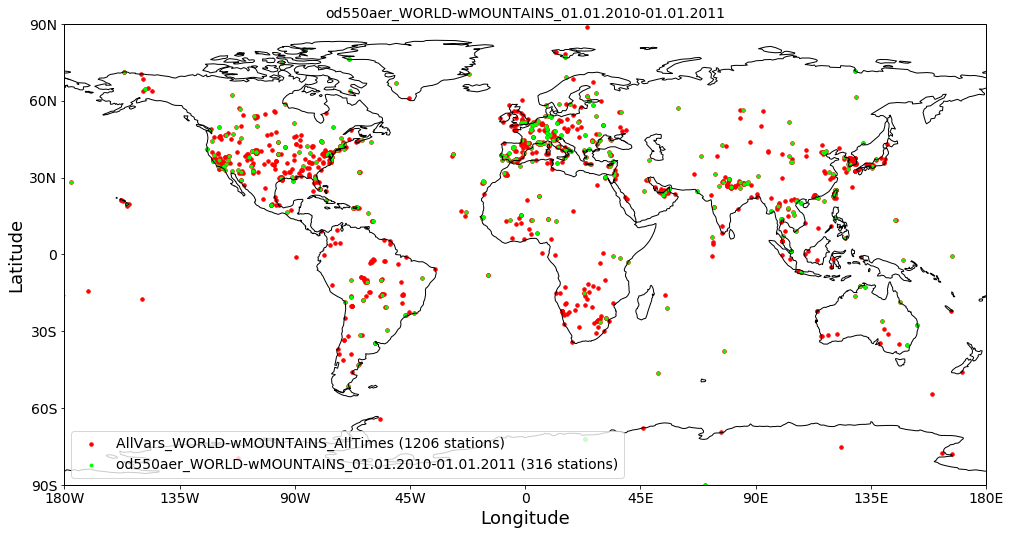

In [2]:
# plots all stations as red dots
ax = data.plot_station_coordinates(markersize=12, color='r')

# add all stations that contain AOD data in 2010 in green
ax = data.plot_station_coordinates(var_name='od550aer', 
                                   start=2010, 
                                   stop=2011, color='lime', ax=ax)

As you can see, you can specify additional input parameters, e.g. to display only stations that contain variable data or to specify a time interval.

In any case, it is always good to know about the help function:

In [3]:
help(data.plot_station_coordinates)

Help on method plot_station_coordinates in module pyaerocom.ungriddeddata:

plot_station_coordinates(var_name=None, filter_name=None, start=None, stop=None, ts_type=None, color='r', marker='o', markersize=8, fontsize_base=10, **kwargs) method of pyaerocom.ungriddeddata.UngriddedData instance
    Plot station coordinates on a map
    
    All input parameters are optional and may be used to add constraints 
    related to which stations are plotted. Default is all stations of all 
    times.
    
    Parameters
    ----------
    
    var_name : :obj:`str`, optional
        name of variable to be retrieved
    filter_name : :obj:`str`, optional
        name of filter (e.g. EUROPE-noMOUNTAINS)
    start 
        start time (optional)
    stop 
        stop time (optional). If start time is provided and stop time not, 
        then only the corresponding year inferred from start time will be 
        considered
    ts_type : :obj:`str`, optional
        temporal resolution
    color : str

##### Quicklook plotting of station timeseries

Time series of individual stations can be plotted as follows:

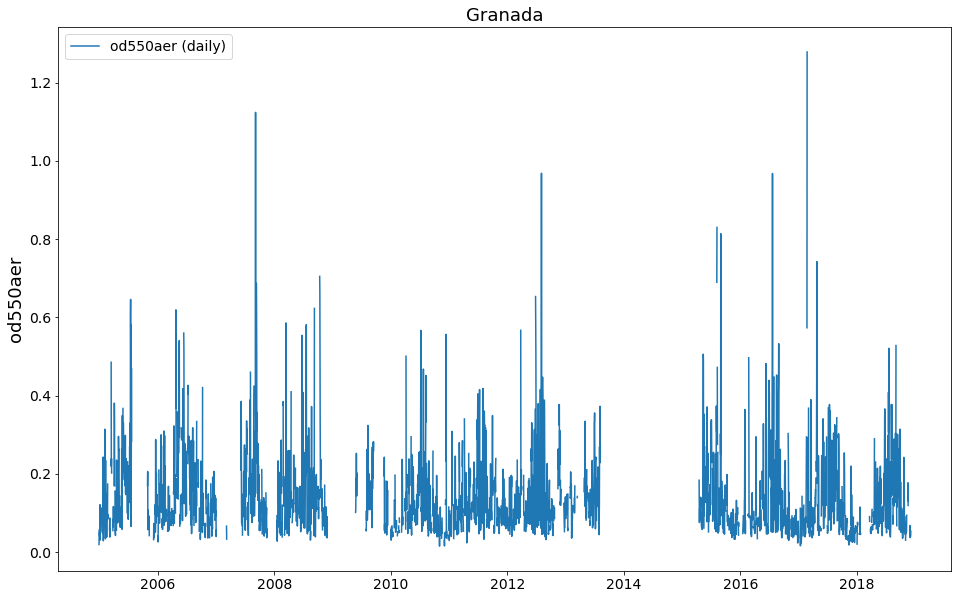

In [4]:
data.plot_station_timeseries(station_name='Granada', var_name='od550aer');

##### Access metadata of the data files that were read

Look into the metadata of the different files. Metadata can be accessed via the `metadata` attribute, and there is one metadatadictionary for each file that was read:

In [5]:
len(data.metadata)

1206

Access metadata of first file (index 0):

In [6]:
data.metadata[0]

OrderedDict([('var_info',
              OrderedDict([('od550aer', OrderedDict([('unit', '1')]))])),
             ('latitude', 45.3139),
             ('longitude', 12.508299999999998),
             ('altitude', 10.0),
             ('station_name', 'AAOT'),
             ('PI', 'Brent_Holben'),
             ('ts_type', 'daily'),
             ('data_id', 'AeronetSunV3Lev2.daily'),
             ('variables', ['od550aer']),
             ('instrument_name', 'sun_photometer')])

##### Filtering of the data

So far, you can filter `UngriddedData` objects by common metadata attributes. For instance:

In [7]:
subset = data.filter_by_meta(latitude=(30, 60), longitude=(0, 45), altitude=(0, 1000))
print(subset)


Pyaerocom UngriddedData
-----------------------
Contains networks: ['AeronetSunV3Lev2.daily']
Contains variables: ['od550aer']
Contains instruments: ['sun_photometer']
Total no. of meta-blocks: 162
Filters that were applied:
 Filter time log: 20190410170216
	latitude: (30, 60)
	longitude: (0, 45)
	altitude: (0, 1000)


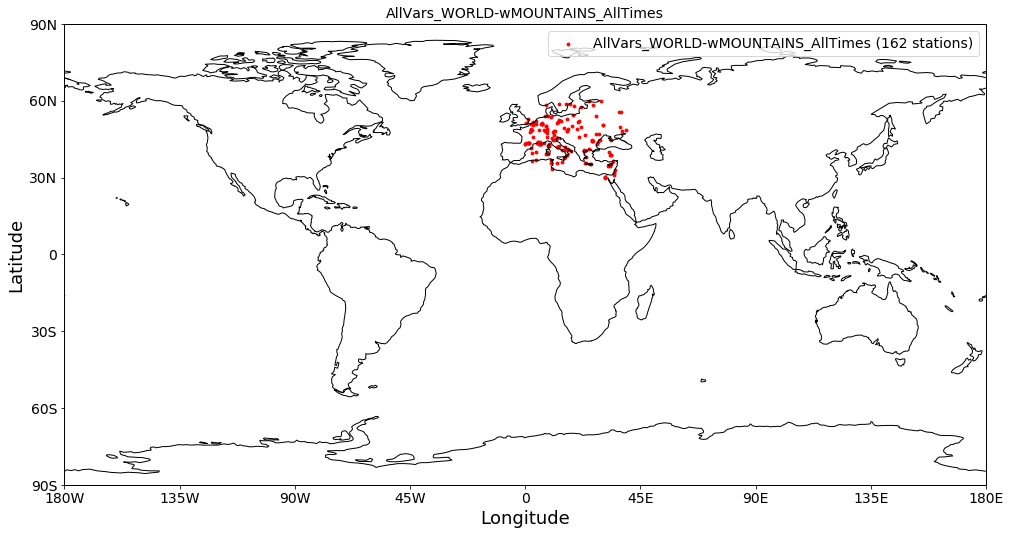

In [8]:
subset.plot_station_coordinates();

##### Other attributes that may be useful

Access all station names and print the first 4:

In [9]:
stat_names = data.station_name
print(stat_names[:4])

['AAOT', 'AOE_Baotou', 'ARM_Ascension_Is', 'ARM_Barnstable_MA']


Essentially, what `data.station_name` does is, it iterates over all metadata-dictionaries (that are stored in `data.metadata`, and are organised *per file that was read*) and extracts the `station_name` attribute and appends it to a list which is then returned by the method. 

Hence, the list of station names corresponds to the list of metadata-blocks / files that are stored in the data object:

In [10]:
len(stat_names)

1206

In a similar manner, you can access coordinates latitude, longitude and altitude arrays for all files.

In [11]:
lons = data.longitude
lons[:4]

[12.508299999999998,
 109.62879999999998,
 -14.349805999999996,
 -70.29006100000001]

In [12]:
lats = data.latitude
lats[:4]

[45.3139, 40.851699999999994, -7.966963999999998, 41.669588999999995]

In [13]:
alts = data.altitude
alts[:4]

[10.0, 1314.0, 341.0, 15.0]

##### List of unique station names

As mentioned earlier, some databases provide more than one data file per station. Since the ungridded reading (see previous) tutorial is done *per data file*, this means that their can be more than one metadata-block per station (not the case here, though). In any case, you can get a list of unique station names using:

In [14]:
unique_names = data.unique_station_names
unique_names[:4]

['AAOT', 'AOE_Baotou', 'ARM_Ascension_Is', 'ARM_Barnstable_MA']

####  `StationData`: Access the data from individual stations

As you could see above the metadata dictionaries in the `UngriddedData` class for each file do only contain the associated metadata. For the sake of performance the actual data arrays are all stored in one big 2D numpy array (which does not need to bother you too much) which is accessible in the `_data` attribute of the `UngriddedData` object (if you like to dive into it).

**In most cases that concern model evaluation, the observation data is analysed station-by-station. For this purpose the StationData class was designed, which is introduced below.**

Starting from an instance of the `UngriddedData` object, the individual station data (i.e. time series of one or more variables + metadata) can be accessed using the method:

**[UngriddedData.to_station_data](https://pyaerocom.met.no/api.html?highlight=to_station_data#pyaerocom.ungriddeddata.UngriddedData.to_station_data)**

or using the square brackets `[]` which is equivalent to the former as it is only a wrapper for `to_station_data`. This meants, calling 

```python
UngriddedData[0]
```

will give you the same output as 

```python
UngriddedData.to_station_data[0]
```

that is, the data associated with the first file that was read (i.e. the first metadata-block in the object) into the `UngriddedData` object (see previous tutorial for details regarding the reading of ungridded observation networks).

To specify the station, you can either use the metadata index of the corresponding data file (`meta_idx=9`, for 10th file) ***or*** you can specify the station name or a wildcard specifying the station name. 

The method returns a [pyaerocom.StationData](https://pyaerocom.met.no/api.html?highlight=stationdata#pyaerocom.stationdata.StationData) object, which is a dictionary-like object which contains data vectors and time-stamps as well as metadata.

Below we will illustrate the several options to access station data (and show that they contain the same data):


##### Option 1. Get station data using the corresponding metadata indices that match the station name

Find index (or indices) that match the station name:

In [15]:
index = data.find_station_meta_indices('Granada')
index

[491.0]

The result shows that there is one file that matches this station name (as we would expect for AERONET data) and the corresponding metadata index is 488.

To access the data, you can use the method `to_station_data`. It helps to have a look into the options of this method:

In [16]:
help(data.to_station_data)

Help on method to_station_data in module pyaerocom.ungriddeddata:

to_station_data(meta_idx, vars_to_convert=None, start=None, stop=None, freq=None, merge_if_multi=True, merge_pref_attr=None, merge_sort_by_largest=True, insert_nans=False) method of pyaerocom.ungriddeddata.UngriddedData instance
    Convert data from one station to :class:`StationData`
    
    Todo
    ----
    - Review for retrieval of profile data (e.g. Lidar data)
    
    Parameters
    ----------
    meta_idx : float
        index of station or name of station.
    vars_to_convert : :obj:`list` or :obj:`str`, optional
        variables that are supposed to be converted. If None, use all 
        variables that are available for this station
    start
        start time, optional (if not None, input must be convertible into
        pandas.Timestamp)
    stop 
        stop time, optional (if not None, input must be convertible into
        pandas.Timestamp)
    freq : str
        pandas frequency string (e.g. 'D' fo

So the first input argument takes either the metadata index, or the name of the station. Here we use the metadata index option using the index that we just retrieved:

In [17]:
granada_opt1 = data.to_station_data(meta_idx=index[0], insert_nans=True)
type(granada_opt1)

pyaerocom.stationdata.StationData

The returned data type is an instance of the [pyaerocom.StationData](https://pyaerocom.met.no/api.html?highlight=stationdata#pyaerocom.stationdata.StationData) class.

**NOTE:** if there is more than one index match for one station (i.e. `data.find_station_meta_indices('Granada')` returns more than one match), then, using Option 1, you would need to call `to_station_data` for each of the index matches. Alternatively you could use either of the following methods, which automatically merge the individual `StationData` objects into one, in case of multiple matches for that station name. 

Let's have a quick look at the `StationData` object (it is a dictionary-like object and simple to use):

##### Option 2: Retrieve station data using the station name directly

In [18]:
granada_opt2 = data.to_station_data('Granada', insert_nans=True)

Other than option 1, in case of multiple meta-index matches, this method automatically merges the individual data objects.

###### Option 3: Use [...] notation

This is a wrapper for the method `to_station_data` so you may use meta-index or station name for access.

In [19]:
granada_opt3_1 = data[index[0]]
granada_opt3_2 = data['Granada']

###### Let's have a look if the data objects are really the same (by plotting the AOD timeseries for the 4 different options):

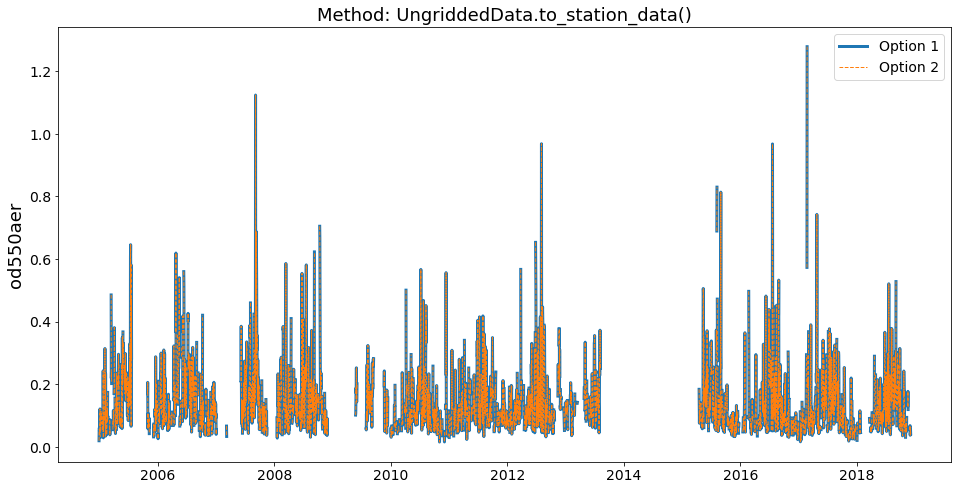

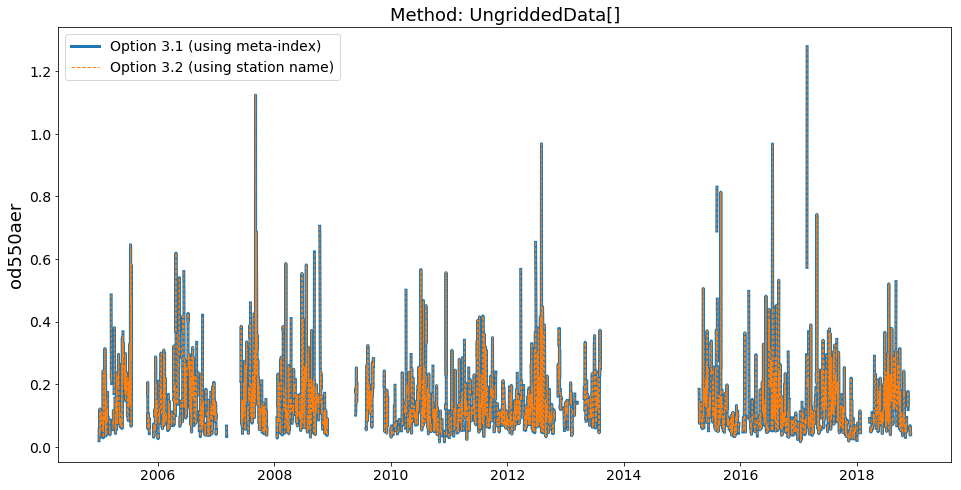

In [20]:
ax = granada_opt1.plot_timeseries('od550aer', lw=3, label='Option 1', tit='Method: UngriddedData.to_station_data()')
granada_opt2.plot_timeseries('od550aer', ls='--', lw=1, label='Option 2',ax=ax)

# plot the results from the [] access option into a new figure (don't pass ax)
ax = granada_opt3_1.plot_timeseries('od550aer', lw=3, label='Option 3.1 (using meta-index)', 
                                    tit='Method: UngriddedData[]')
granada_opt3_2.plot_timeseries('od550aer', ls='--', lw=1, label='Option 3.2 (using station name)',ax=ax)

Looks good. Let's explore the `StationData` object a little more (you can print it and it will get you a nice overview):

In [21]:
print(granada_opt1)


Pyaerocom StationData
---------------------
var_info (BrowseDict([('od550aer', OrderedDict([('unit', '1'), ('overlap', False), ('ts_type', 'daily')]))]))
   od550aer (<class 'collections.OrderedDict'>)
    unit: 1
    overlap: False
    ts_type: daily
station_coords ({'latitude': 37.163999999999994, 'longitude': -3.605, 'altitude': 680.0})
   latitude: 37.163999999999994
   longitude: -3.605
   altitude: 680.0
data_err (BrowseDict([('od550aer', array([nan, nan, nan, ..., nan, nan, nan]))]))
   od550aer (array, 2980 items)
   [nan
    nan
    ...
    nan
    nan]

overlap: 
filename: None
station_id: None
station_name: Granada
instrument_name: sun_photometer
PI: Brent_Holben
country: None
ts_type: daily
latitude: 37.163999999999994
longitude: -3.605
altitude: 680.0
data_id: AeronetSunV3Lev2.daily
dataset_name: None
data_product: None
data_version: None
data_level: None
revision_date: None
ts_type_src: daily
stat_merge_pref_attr: None
data_revision: 20190311

Data arrays
...............

You can see that the `StationData` object contains both metadata (e.g. `PI`) and data vectors which can be either 1D numpy arrays or python lists (e.g. `dtime`) or `pandas.Series` objects (e.g. variable `od550aer`). All attributes can be accessed and manipulated either using dictionary style access (i.e. `[]` notation), or using the `.` operator. 

Here some examples:

In [22]:
# get longitude using "[]" notation
granada_opt1['longitude']

-3.605

In [23]:
# get longitude using "." notation
granada_opt1.longitude

-3.605

In [24]:
# assign longitude using "." notation and display new value (again using "[]" notation)
granada_opt1.longitude = 42
granada_opt1['longitude']

42

In [25]:
granada_opt1['station_name']

'Granada'

Get station name:

In [26]:
granada_opt1.station_name

'Granada'

##### Small detour through the `pandas` world

As you can see in the output above, the time-series data in the `StationData` object is an instance of the `pandas.Series` class.

In [27]:
aod_data = granada_opt1.od550aer
type(aod_data)

pandas.core.series.Series

**NOTE**: pyaerocom relies on pandas, so if you are not familiar with the pandas library, it is a good advice to make yourself familiar with it (especially if you are interested in timeseries analysis). See [here for a short introduction into pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html). 

Anyways, you should know about the 2 basic datatypes of pandas which are:

- [pandas.Series](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html)
- [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame
.html)

Both objects are very similar in their handling and the `Series` class can be imagined as a *single column* of the `Dataframe` object which is a table-like object that has columns (e.g. variables) and rows (e.g. time-stamps). It is hence, easy to go back and forth between the two objects.

Anyways, here is some examples what you can do with an instance of the `pandas.Series` object that we just accessed from the `pyaerocom.StationData` object from Granada (and which we named `aod_data`).

First, you can get a basic clue about the data by using the `describe` method:

In [28]:
aod_data.describe()

count    2980.000000
mean        0.138233
std         0.103543
min         0.015534
25%         0.071486
50%         0.108491
75%         0.171623
max         1.278507
dtype: float64

Second, you may plot it:

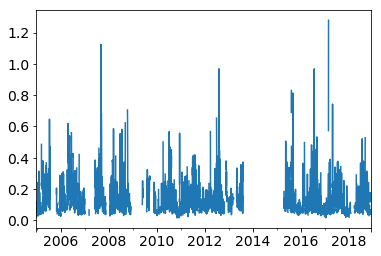

In [29]:
aod_data.plot();

Third, you may extract subsets using *fancy indexing*:

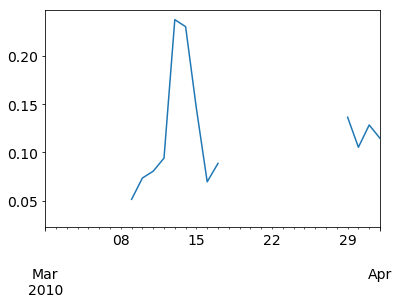

In [30]:
aod_data_march2010 = aod_data['2010-3-1':'2010-4-1']
aod_data_march2010.plot()

Or fourth, resample to another frequency:

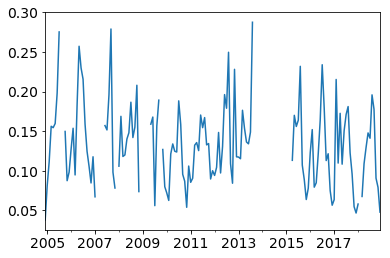

In [31]:
aod_data_monthly = aod_data.resample('M', 'mean')
aod_data_monthly.plot()

Or fifth, resample to lower frequency, but require a minimum number of observations per period:

In [32]:
monthly_with_count = aod_data.resample('M').agg(['mean', 'count'])
monthly_with_count.head()

,mean,count
2004-12-31,0.038038,2
2005-01-31,0.081300,28
2005-02-28,0.111567,24
2005-03-31,0.156312,17
2005-04-30,0.154527,26


Now, here you see an example, where `pandas` automatically converted our Series (which is single variable) to a  DataFrame (which is a table), since we told the resampler above, to aggregate monthly mean and monthly count. 

Now let's say we require at least 15 observations (here, days, since our original dataset is in daily resolution) per month:

In [33]:
invalid_mask = monthly_with_count['count'] < 15
monthly_with_count['mean'][invalid_mask] = np.nan
aod_monthly_min15d = monthly_with_count['mean']
aod_monthly_min15d.head()

2004-12-31         NaN
2005-01-31    0.081300
2005-02-28    0.111567
2005-03-31    0.156312
2005-04-30    0.154527
Freq: M, Name: mean, dtype: float64

Now plot both the monthly timeseries from above without constraint and the one with constraint:

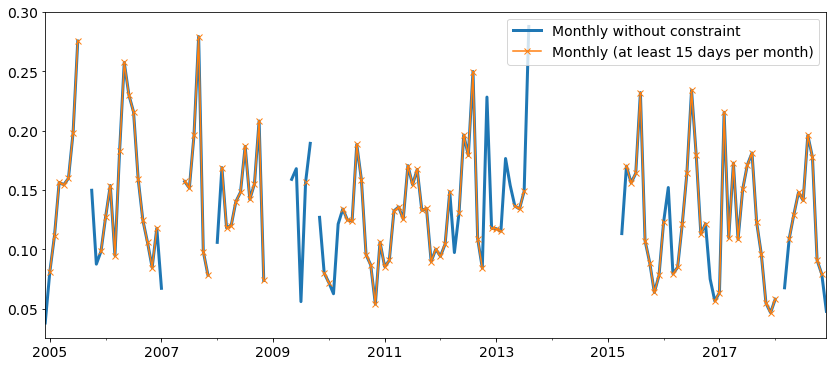

In [34]:
ax = aod_data_monthly.plot(label='Monthly without constraint', lw=3, figsize=(14,6))
aod_monthly_min15d.plot(ax=ax, style='x-', label='Monthly (at least 15 days per month)')
ax.legend();

As you can see, there is quite some months missing when applying the filter.

You may also be intersted in a climatology:

In [35]:
aod_monthly_climatology = aod_data_monthly.groupby(aod_data_monthly.index.month).mean()
aod_monthly_climatology

1     0.090553
2     0.130528
3     0.114070
4     0.132565
5     0.146914
6     0.164997
7     0.174380
8     0.192138
9     0.146022
10    0.115004
11    0.091344
12    0.080672
dtype: float64

And do the same for the monthly data with minimum 15 days per month that we created above:

In [36]:
aod_monthly_climatology_min15d = aod_monthly_min15d.groupby(aod_monthly_min15d.index.month).mean()
aod_monthly_climatology_min15d

1     0.091438
2     0.137147
3     0.119908
4     0.136718
5     0.145819
6     0.164751
7     0.184243
8     0.183453
9     0.141699
10    0.111529
11    0.072294
12    0.089056
Name: mean, dtype: float64

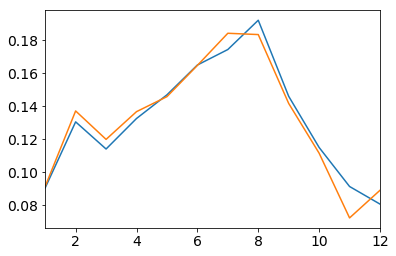

In [37]:
ax = aod_monthly_climatology.plot(label='Monthly climatology (no constraint)')
aod_monthly_climatology_min15d.plot(label='Monthly climatology (min 15 days/month)')

That was enough of a detour into the pandas world. As you shall see below, some of these pandas features are also provided in the pyaerocom data objects (e.g. resampling) and more will follow soon!

##### Plotting of timeseries data directly from [StationData](https://pyaerocom.met.no/api.html?highlight=stationdata#pyaerocom.stationdata.StationData) class

Let's come back to the `StationData` object. Below are some more examples that show how you can plot the timeseries directly from the `StationData` object. This includes to do a resampling out of the box when plotting:

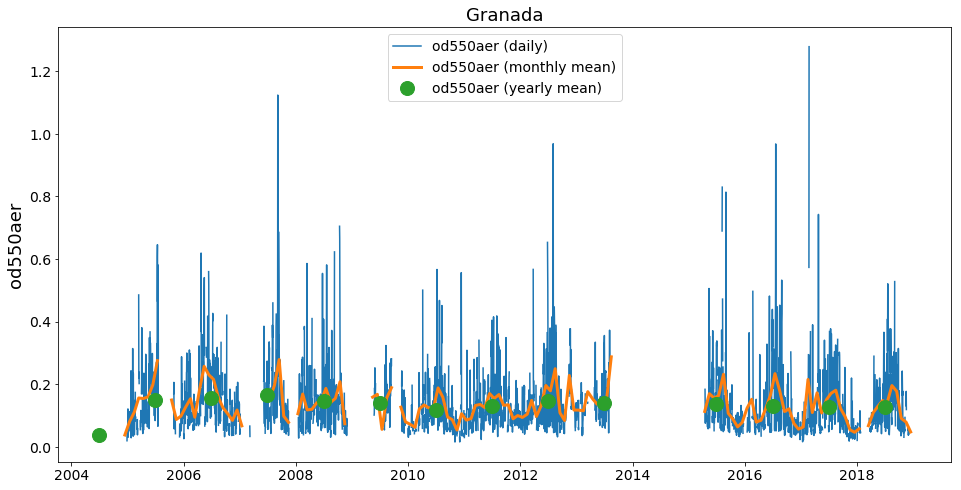

In [38]:
ax = granada_opt1.plot_timeseries('od550aer')
ax = granada_opt1.plot_timeseries('od550aer', freq='monthly', lw=3, ax=ax)
granada_opt1.plot_timeseries('od550aer', freq='yearly', ls='none', marker='o', ms=14, ax=ax);

The resampling of the timeseries in the plotting method is done automatically (if input `ts_type` is provided). 

Currently, this does not apply additional constraints such as a minimum number of available observations when downsampling (like we showed above). 
From the yearly data (green dots) you can see clearly that this can be an issue, especially for the first and the last year.

In order to account for it, you may to the following:

In [39]:
# convert to monthly with at least 5 days per month
od550aer_monthly = granada_opt1.resample_timeseries('od550aer', 'monthly', 'mean', min_num_obs=5)

# assign to our StationData
granada_opt1['od550aer_monthly'] = od550aer_monthly

# convert to yearly with at least 6 months per year
od550aer_yearly_constrained = granada_opt1.resample_timeseries('od550aer_monthly', 'yearly', 'mean', min_num_obs=6)

Compare the result with the yearly product plotted above:

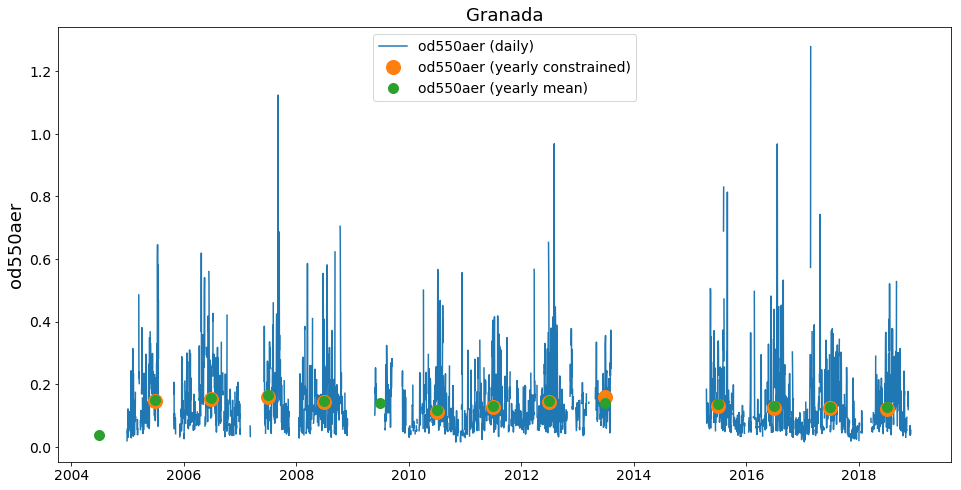

In [40]:
ax = granada_opt1.plot_timeseries('od550aer')
ax.plot(od550aer_yearly_constrained, ls='none', marker='o', ms=14, label='od550aer (yearly constrained)')
ax = granada_opt1.plot_timeseries('od550aer', freq='yearly', ls='none', marker='o', ms=10, ax=ax)